# Follow the Cryptocurrency

One reason why graphs are so powerful is that they lend themselves naturally to **visualization** and **manual exploration of complicated data**. GraphLab Create provides fast and intuitive tools for graph investigation; in this notebook we show how to use these tools to explore the **network of bitcoin users and transactions**.

By computing global network statistics, visualizing local network neighborhoods, and following money trails, we show how easy it is to identify **key network hubs** and **users who are likely involved in suspicious activity**. To see each of these tasks in action, we'll work through the following sections:

1. [What is bitcoin?](#What-is-bitcoin)
2. [Identifying key network hubs](#Identifying-key-network-hubs)
3. [Following WikiLeaks donations](#Following-WikiLeaks-donations)
4. [Investigating the *allinvain* heist](#Investigating-the-allinvain-heist)

## What is bitcoin?

Bitcoin is a 5-year-old digital currency that uses public-key cryptography to facilitate ownership and transactions. Users store private keys to prove they own some quantity of bitcoins, typically when transferring bitcoins to another user. All bitcoin transactions are recorded publicly, so they may be verified by the community (a process which results in the creation of new bitcoins, i.e. bitcoin mining). Although there is widespread belief that bitcoin transactions are anonymous (e.g. [CNN Money article](http://money.cnn.com/infographic/technology/what-is-bitcoin/)), the public verification process prevents true anonymity. See the [Bitcoin wiki](https://en.bitcoin.it/wiki/Introduction#Bitcoin_Basics) and [Wikipedia](http://en.wikipedia.org/wiki/Bitcoin) for more information on how bitcoin works.

Bitcoin transactions appear anonymous because transactions only contain input and output public key addresses, but not information about the people who own those addresses. However, when multiple bitcoin addresses are used as inputs to a transaction, the addresses must be controlled by the same agent. In a fascinating 2011 [paper](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=6113303&tag=1) ([arXiv version](http://arxiv.org/pdf/1107.4524.pdf?origin=publication_detail)) Reid and Harrigan used this loophole to construct a network of users in the bitcoin network. In this network, vertices represent real-world people (or institutions) and edges represent bitcoin transfers; there are often multiple edges between a pair of users.

This notebook replicates many of the analyses in Reid and Harrigan, using [Reid and Harrigan's data, available on their blog](http://anonymity-in-bitcoin.blogspot.com/2011/09/code-datasets-and-spsn11.html). Our first task is to get our environment set up by **importing the required libraries**. We use the matplotlib library to show line plots, and pandas for time series indexing.

In [1]:
try:
    import graphlab as gl
    import graphlab.aggregate as agg
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    import datetime as dt
    %matplotlib inline
    
except:
    raise ImportError("Key libraries cannot be loaded.")

[INFO] 1447091795 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_FILE to /Users/roman/miniconda2/envs/rc17/lib/python2.7/site-packages/certifi/cacert.pem
1447091795 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_DIR to 
This commercial license of GraphLab Create is assigned to engr@turi.com.

[INFO] Start server at: ipc:///tmp/graphlab_server-98503 - Server binary: /Users/roman/miniconda2/envs/rc17/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1447091795.log
[INFO] GraphLab Server Version: 1.6.911


We also define a handful of **plot aesthetics** for better visualizations.

In [2]:
rcParams['figure.figsize'] = (10, 10)
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 22
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

def clean_plot(ax):
    for x in ax.spines.values():
        x.set_visible(False)
    ax.grid(True, 'major', color='w', linestyle='-', linewidth=1.4)
    ax.patch.set_facecolor('0.92')
    ax.set_axisbelow(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

Next we **load the data**, which is in the form of a text file where **each row represents a single bitcoin transaction**. For each transaction, some amount of bitcoints ("btc") is sent from the source user ("src") to the destination user ("dst"). The following cell checks for an SFrame called *user_edges_2011-07-13* in the working directory; if the SFrame exists, it's loaded, and if it doesn't, it's downloaded from a public Amazon S3 bucket and saved locally.

In [3]:
import os

f_userdata = 'user_edges_2011-07-13'

if os.path.exists(f_userdata):
    sf = gl.SFrame(f_userdata)
else:
    url_userdata = 'https://static.turi.com/datasets/bitcoin/{}.txt'.format(f_userdata)
    sf = gl.SFrame.read_csv(url_userdata, delimiter='\t', header=False,
                              column_type_hints={'X1': int, 'X2': int, 'X3': float})
    sf.rename({'X1': 'src', 'X2': 'dst', 'X3': 'btc', 'X4': 'timestamp'})
    sf.save(f_userdata)

Once the dataset is loaded, the GraphLab Canvas gives us a quick intuition about what's in each column.

In [4]:
# Show graphs and sframes inside ipython notebook
gl.canvas.set_target('ipynb')

sf.show()

For easier handling of the timestamps, we convert the column to a datetime type. For the purpose of this notebook, we only need the date, so we'll set the time for all observations to 00:00:00. Later we'll need the Year and Month specifically so we also break them out now.

In [5]:
sf['timestamp'] = sf['timestamp'].str_to_datetime('%Y-%m-%d-%H-%M-%S')
sf.add_columns(sf['timestamp'].split_datetime(column_name_prefix=None, limit=['year', 'month', 'day']))

src,dst,btc,timestamp,year,month,day
1,5994,8.94,2011-07-04 09:05:56,2011,7,4
905914,20572,0.01,2011-06-23 19:10:01,2011,6,23
905914,622803,220.07592886,2011-06-23 19:10:01,2011,6,23
823336,118969,2.12,2011-05-16 01:58:01,2011,5,16
823336,330686,0.56210609,2011-05-16 01:58:01,2011,5,16
2,282877,0.15,2011-05-23 04:48:17,2011,5,23
2,902253,1.35,2011-05-23 04:48:17,2011,5,23
448634,40297,0.88,2011-06-11 06:00:01,2011,6,11
448634,71810,0.11,2011-06-11 06:00:01,2011,6,11
373684,2909,35.0,2010-10-19 10:37:48,2010,10,19


For the sake of interpretability, we'll also load **historical dollar prices for bitcoin**, and use dollar values of transactions for displaying the graphs. Once again, we only need date information, so we zero out the times.

In [6]:
f_price = 'https://static.turi.com/datasets/bitcoin/market-price.csv'

sf_price = gl.SFrame.read_csv(f_price, delimiter=',', header=False,
                              column_type_hints=[str, float])
sf_price.rename({'X1': 'timestamp', 'X2': 'close-price'})

sf_price['timestamp'] = sf_price['timestamp'].str_to_datetime('%d/%m/%Y')
sf_price.add_columns(sf_price['timestamp'].split_datetime(column_name_prefix=None, limit=['year', 'month', 'day']))
sf_price.head(5)

PROGRESS: Downloading https://static.turi.com/datasets/bitcoin/market-price.csv to /var/tmp/graphlab-roman/98503/8a44023d-3daf-42fe-9f38-b1cfeaf48ace.csv
PROGRESS: Finished parsing file https://static.turi.com/datasets/bitcoin/market-price.csv
PROGRESS: Parsing completed. Parsed 1916 lines in 0.027287 secs.


timestamp,close-price,year,month,day
2009-01-03 00:00:00,0.0,2009,1,3
2009-01-04 00:00:00,0.0,2009,1,4
2009-01-05 00:00:00,0.0,2009,1,5
2009-01-06 00:00:00,0.0,2009,1,6
2009-01-07 00:00:00,0.0,2009,1,7


To match the transaction data to the historical prices, we use a [**left SFrame join**](https://graphlab.com/products/create/docs/generated/graphlab.SFrame.join.html#graphlab.SFrame.join) on the timestamps. From the price dataset, we need only the dollar column.

After the prices are joined we compute the value of each transaction and create a nicely formatted row for graph visualizations.

In [7]:
sf = sf.join(sf_price, on=['year', 'month', 'day'], how='left')
sf.remove_column('timestamp.1')

sf['dollar'] = sf.apply(lambda x: x['btc'] * x['close-price'])
sf['dollar_label'] = sf['dollar'].apply(lambda x: '$' + str(round(x, 2)))

Once the data are all loaded, we construct the transaction graph.

In [8]:
g = gl.SGraph().add_edges(sf, src_field='src', dst_field='dst')

## Identifying key network hubs

The graph summary shows there are nearly **900,000 users** and **1.9 million transactions**. Compared to the number of potential connections between pairs of users, the bitcoin network has relatively few edges. Because there can be multiple transactions per pair of users (not to mention transactions where a user sends money to himself), however, graph *density* (number of edges divided by number of possible edges) is not defined.

In [9]:
g.summary()

{'num_edges': 1961636, 'num_vertices': 881678}

**Activity in the bitcoin network has increased quite rapidly**, both in terms of number of transactions per month and the number of users involved in each month's transactions. Note the sharp drops at the end of the time series - these are artifact of the dataset ending in the middle of a month. First, the **number of transactions per month** (in hundreds of thousands):

/Users/roman/miniconda2/envs/rc17/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


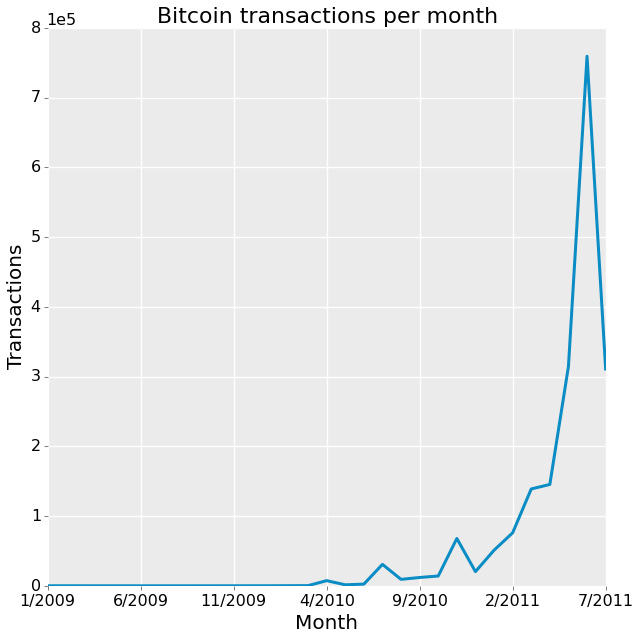

In [10]:
# find count of transactions per month
transaction_count = sf.groupby(['year', 'month'], agg.COUNT).sort(['year', 'month'], ascending=True)

# sort the results by year and month
n_month = transaction_count.num_rows()

# add a column with x-axis plot labels
transaction_count['label'] = transaction_count['month'].astype(str) + "/" + transaction_count['year'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(transaction_count['Count'], lw=3, color='#0a8cc4')  # graphlab color!
ax.set_title("Bitcoin transactions per month")
ax.set_ylabel("Transactions")
ax.set_xlabel("Month")

xticks = ax.get_xticks().astype(int)
transaction_count_label = list(transaction_count['label'])
ticklabels = list([transaction_count_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

clean_plot(ax)
fig.show()

Now the **number of unique users per month**, broken into two sets: users who make bitcoin payments and users who receive bitcoin payments (there are many users in both categories, of course). The y-axis is again in hundreds of thousands of users.

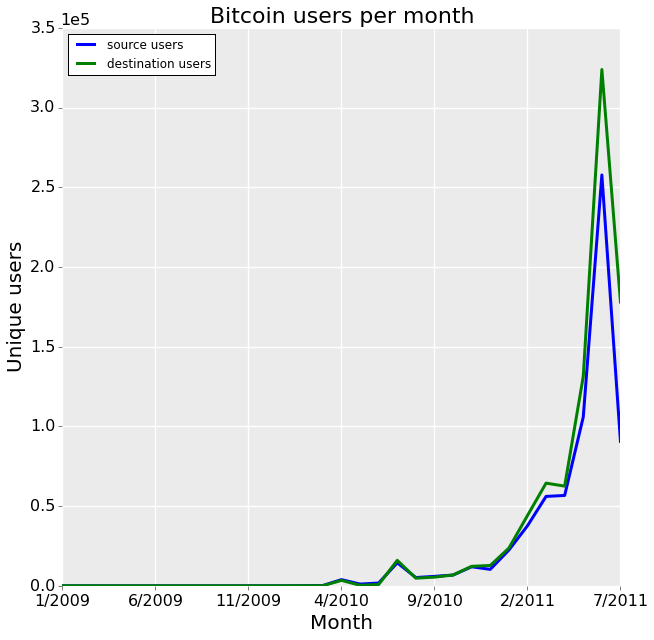

In [11]:
# find the number of unique source users by month
month_source_count = sf.groupby(['year', 'month', 'src'], agg.COUNT).sort(['year', 'month'], ascending=True)
source_count = month_source_count.groupby(['year', 'month'], agg.COUNT).sort(['year', 'month'], ascending=True)

# find the number of unique destination users by month
month_dest_count = sf.groupby(['year', 'month', 'dst'], agg.COUNT).sort(['year', 'month'], ascending=True)
dest_count = month_dest_count.groupby(['year', 'month'], agg.COUNT).sort(['year', 'month'], ascending=True)

# add columns with x-axis plot labels
source_count['label'] = source_count['month'].astype(str) + "/" + source_count['year'].astype(str)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(source_count['Count'], lw=3, label='source users')
ax.plot(dest_count['Count'], lw=3, label='destination users')
ax.set_title("Bitcoin users per month")
ax.set_ylabel("Unique users")
ax.set_xlabel("Month")
ax.legend(loc='upper left')

xticks = ax.get_xticks().astype(int)
source_count_label = list(source_count['label'])
ticklabels = list([source_count_label[i] for i in xticks])
ax.set_xticklabels(ticklabels)

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

clean_plot(ax)
fig.show()

A critical attribute of any financial network is the **identities of the network hubs**. The first way to identify these nodes is to **find users with very large in-degree, out-degree, and overall degree**, i.e. number of payments made, payments received, and total transactions. To compute the degrees we use the SGraph's **triple_apply** method, which computes a given function over all triples of source node -- edge -- destination node.

In [12]:
def count_degree(src, edge, dst):
    dst['in_degree'] += 1
    src['out_degree'] += 1
    return (src, edge, dst)

def get_degree(g):
    new_g = gl.SGraph(g.vertices, g.edges)
    new_g.vertices['in_degree'] = 0
    new_g.vertices['out_degree'] = 0
    return new_g.triple_apply(count_degree, ['in_degree', 'out_degree']).get_vertices()

sf_degree = get_degree(g)
sf_degree['total_degree'] = sf_degree['in_degree'] + sf_degree['out_degree']

The log-log plot of cumulative degree shows there is a handful of very active nodes in the network, and two users in particular are way more active than anybody else. To generate this plot, we'll use utilities from the numpy library.

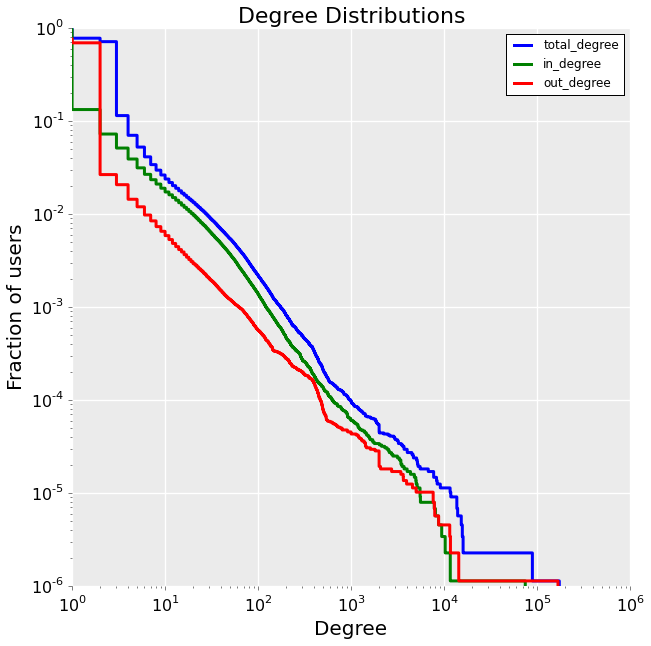

In [13]:
import numpy as np

fig, ax = plt.subplots()

for deg_type in ['total_degree', 'in_degree', 'out_degree']:
    counts = np.bincount(list(sf_degree[deg_type]))
    ecdf = np.cumsum(counts) / float(sf_degree.num_rows())
    ax.step(range(len(ecdf)), 1 - ecdf, lw=3, where='post', label=deg_type)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Degree")
ax.set_ylabel("Fraction of users")
ax.set_title("Degree Distributions")
clean_plot(ax)
fig.show()

In [14]:
print "In-degree outliers"
print sf_degree.topk('in_degree', k=5)

print "Out-degree outliers"
print sf_degree.topk('out_degree', k=5)

In-degree outliers
+------+-----------+------------+--------------+
| __id | in_degree | out_degree | total_degree |
+------+-----------+------------+--------------+
|  23  |   74628   |   14381    |    89009     |
|  18  |   11657   |    3648    |    15305     |
|  59  |   10278   |    3429    |    13707     |
|  16  |    9422   |    4570    |    13992     |
|  74  |    8715   |    5003    |    13718     |
+------+-----------+------------+--------------+
[5 rows x 4 columns]

Out-degree outliers
+--------+-----------+------------+--------------+
|  __id  | in_degree | out_degree | total_degree |
+--------+-----------+------------+--------------+
|  175   |    5514   |   167767   |    173281    |
|   23   |   74628   |   14381    |    89009     |
| 791028 |    100    |   11708    |    11808     |
| 321039 |     98    |   11507    |    11605     |
|  1995  |    371    |    8736    |     9107     |
+--------+-----------+------------+--------------+
[5 rows x 4 columns]



Who are the nodes in the tail of these distributions?

The prolific bitcoin recipients are users with IDs *23*, *18*, and *59*. The most frequent senders are *175*, *23*, and *791028*. Each of these users have over 10,000 incoming or outoing transactions (or both), and they are most likely bitcoin exchanges or related businesses.

Let's keep an eye on user ID numbers *23* and *175*, who have far more transactions than anybody else. Another way to look for outliers is by **finding anomalously large transactions**. For context, we first look at the distribution of non-outlier transactions, defined here as transfers of 5 or fewer bitcoins. The *frequency* in the following plot is in the hundreds of thousands of transactions.

In [15]:
btc_small = sf[sf['btc'] <= 5]['btc']
print "Number of small transactions:", len(btc_small)
print "Proportion of all transactions:", float(len(btc_small)) / sf.num_rows()
btc_small.show()

Number of small transactions: 1354923
Proportion of all transactions: 0.690710712895


The majority of transactions are very small, in terms of bitcoins. With this context in mind, let's look at the largest transactions in the network.

In [16]:
sf[['src', 'dst', 'btc', 'timestamp', 'dollar']].topk('btc', k=5)

src,dst,btc,timestamp,dollar
56871,16256,432109.876543,2011-06-12 13:57:20,10798425.8148
16256,307659,432077.766543,2011-06-19 19:17:28,8156159.16793
22746,907453,424242.424242,2011-06-23 07:50:15,6787878.78787
34595,380076,400000.0,2011-01-27 00:33:55,166960.0
307659,754833,382077.766543,2011-06-19 23:01:22,7212329.16793


**A handful of transactions are enormous** - over 400,000 BTC! User *307659* is involved in two of the five largest transactions, so this is another user to watch closely. In fact, this user only has three transactions in the whole network, all on June 19, 2011:

In [17]:
u307659_edges = g.get_edges(src_ids=[307659, None], dst_ids=[None, 307659])
u307659_edges.head()

Columns:
	__src_id	int
	__dst_id	int
	btc	float
	timestamp	datetime
	year	int
	month	int
	day	int
	close-price	float
	dollar	float
	dollar_label	str

Rows: 3

Data:
+----------+----------+---------------+---------------------+------+-------+-----+
| __src_id | __dst_id |      btc      |      timestamp      | year | month | day |
+----------+----------+---------------+---------------------+------+-------+-----+
|  16256   |  307659  | 432077.766543 | 2011-06-19 19:17:28 | 2011 |   6   |  19 |
|  307659  |  643745  |    50000.0    | 2011-06-19 23:01:22 | 2011 |   6   |  19 |
|  307659  |  754833  | 382077.766543 | 2011-06-19 23:01:22 | 2011 |   6   |  19 |
+----------+----------+---------------+---------------------+------+-------+-----+
+-------------+---------------+--------------+
| close-price |     dollar    | dollar_label |
+-------------+---------------+--------------+
|   18.8766   | 8156159.16793 | $8156159.17  |
|   18.8766   |    943830.0   |  $943830.0   |
|   18.8766   | 7212329.16793 | $7212329.17  |
+-------------+---------------+--------------+
[3 rows x 10 columns]

Finally, we can use **[pagerank](https://graphlab.com/products/create/docs/generated/graphlab.pagerank.create.html#graphlab.pagerank.create) to identify the most *influential* users** in the graph, using the existence of transactions (but not their size). Once again users *23*, *18*, and *59* show up as key hubs in the network.

In [18]:
pr = gl.pagerank.create(g, verbose=False)
pr_out = pr.get('pagerank')
pr_out.topk('pagerank', k=5)

__id,pagerank,delta
23,11380.8930204,9.10550351699
18,4124.68311515,3.32566704506
74,2722.93822325,4.15554219738
16,2501.06912144,2.49029993988
59,2302.3725134,3.85763174875


## Following WikiLeaks donations

[WikiLeaks](https://wikileaks.org/) is an organization that seeks to provide a "secure and anonymous way for sources to leak information"; it is perhaps most known as the publisher of [classified documents leaked by Chelsea Manning](http://en.wikipedia.org/wiki/United_States_diplomatic_cables_leak) in 2010. Following the release of these documents, WikiLeaks was [subjected to a major financial blockade](http://www.forbes.com/sites/jonmatonis/2012/08/20/wikileaks-bypasses-financial-blockade-with-bitcoin/) and sought to raise funds through alternative channels. On June 14, 2011 the organization [solicited bitcoin donations](https://twitter.com/wikileaks/status/80774521350668288) by tweeting one of its public addresses. The WikiLeaks website allows donors to generate a new address for each donation (which would be hard to track), but many donors simply used the tweeted address. Let's **follow the flow of money into and out of the public WikiLeaks address**.

The first task is to retrieve the subset of bitcoin transactions that are near the WikiLeaks address, also known as the **egocentric network**. This will help us to figure out how much money has been donated to WikiLeaks and to identify key donors, suppliers, and financial intermediaries. The SGraph [**get_neighborhood**](https://graphlab.com/products/create/docs/generated/graphlab.SGraph.get_neighborhood.html#graphlab.SGraph.get_neighborhood) method allows us to retrieve the egocentric network in one line of code. The Wikileaks node is highlighted in purple.

In [19]:
idx_wleaks = 9264  # user ID from Reid-Harrigan, based on the public bitcoin address

wleaks_net = g.get_neighborhood(ids=idx_wleaks, radius=1, full_subgraph=False)
wleaks_net.show(highlight=[idx_wleaks])

In [20]:
sf_wleaks = wleaks_net.get_edges().sort('timestamp', ascending=True)
sf_wleaks = sf_wleaks.add_row_number()

By plotting the bitcoin balance over time, we can see **WikiLeaks quickly distributed its donations to less traceable addresses**. For better interpretability the balance is expressed in U.S. dollars, based on the exchange rate at the end of each day.

In [21]:
balance = [0.] * sf_wleaks.num_rows()
balance[0] = sf_wleaks[0]['dollar']

for i in range(1, sf_wleaks.num_rows()):
    if sf_wleaks[i]['__src_id'] == idx_wleaks and sf_wleaks[i]['__dst_id'] != idx_wleaks:
        balance[i] = balance[i - 1] - sf_wleaks[i]['dollar']
        
    elif sf_wleaks[i]['__src_id'] != idx_wleaks and sf_wleaks[i]['__dst_id'] == idx_wleaks:
        balance[i] = balance[i - 1] + sf_wleaks[i]['dollar']

    else:
        balance[i] = balance[i - 1]
        
sf_wleaks['balance'] = balance

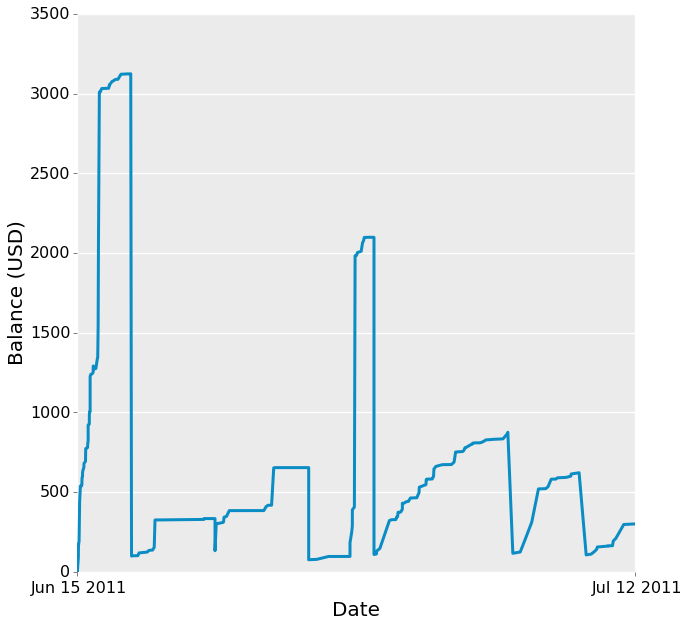

In [22]:
fig, ax = plt.subplots()
ax.plot(sf_wleaks['timestamp'].astype(int), sf_wleaks['balance'], lw=3, color='#0a8cc4')
ax.set_ylabel("Balance (USD)")
ax.set_xlabel("Date")

xlim_dates = gl.SArray([sf_wleaks[0]['timestamp'], sf_wleaks[-1]['timestamp']])
ax.set_xlim(xlim_dates.astype(int))
ax.set_xticks(xlim_dates.astype(int))
ax.set_xticklabels(xlim_dates.datetime_to_str('%b %d %Y'))

clean_plot(ax)
fig.show()

The whole egocentric network is hard to digest. Let's **focus on where WikiLeaks sent the money**, by retrieving outgoing edges from the WikiLeaks address. Remember that the wide end of the edges indicate the destination nodes (i.e. bitcoin recipients). WikiLeaks is again highlighted in purple.

In [23]:
net1 = gl.SGraph().add_edges(wleaks_net.get_edges(src_ids=[idx_wleaks]),
                             src_field='__src_id', dst_field='__dst_id')
net1.show(vlabel='id', highlight=[idx_wleaks], elabel='dollar_label',
          arrows=True, vlabel_hover=False, elabel_hover=False)

Wikileaks sent several payments of about \$0.20 (0.01BTC), which seems unusual, but may be an artifact of the structure of bitcoin transactions. More importantly, there were **several large payments**, to user IDs *384012*, *376702*, *283026*, *447905*, and *344528*. Interestingly, **none of the users who received money from WikiLeaks have any dealings with each other** (at least in this dataset). When we query the egocentric neighborhoods around each of the targets with radius set to 0, we are effectively only looking for edges between this subset of nodes. By plotting the subgraph we see there are no connections.

In [24]:
targets = net1.get_edges()['__dst_id']
net2 = g.get_neighborhood(ids=targets, radius=0, full_subgraph=True)
net2.show(vlabel='id', highlight=targets)

Because there are only a handful of direct recipients of WikiLeaks' money, we can **examine each node's neighborhood more closely**. For brevity we'll look at only the recipients that received over 100BTC.

In [25]:
net2_edges = net2.get_edges()
targets = net2_edges[net2_edges['btc'] > 100]['__dst_id']

In [26]:
net3 = g.get_edges(src_ids=targets)
net3

__src_id,__dst_id,btc,timestamp,year,month,day,close-price,dollar,dollar_label


In [27]:
net3 = g.get_edges(dst_ids=targets)
net3

__src_id,__dst_id,btc,timestamp,year,month,day,close-price,dollar,dollar_label
9264,283026,150.0,2011-06-17 17:19:05,2011,6,17,19.3898,2908.47,$2908.47
9264,384012,115.0,2011-06-29 20:48:42,2011,6,29,17.3,1989.5,$1989.5


The only edges in the graph for these user IDs are the transfers from WikiLeaks (user *9264*), suggesting **the money stopped with these users** for some reason. As with the highly active and influential users in the first section, users *283026* and *384012* merit further investigation.

## Investigating the *allinvain* heist

In June 2011, a bitcoin user known as *allinvain* reported on a popular bitcoin forum that he had lost [25,000 bitcoins to a thief](https://bitcointalk.org/index.php?topic=16457.0). Because all bitcoin transactions are public, the thief's bitcoin address is known, but tracking the stolen money is difficult because the thief disguised the trail with lots of small transactions. With GraphLab Create we can **investigate the users and transactions connected to the heist** and **track the stolen money**.

As with the WikiLeaks case, our first step is to **visualize the egocentric network** around the key players with the [**get_neighborhood**](https://graphlab.com/products/create/docs/generated/graphlab.SGraph.get_neighborhood.html#graphlab.SGraph.get_neighborhood) method of SGraph.

In [28]:
idx_thief = 16657   # user IDs from Reid-Harrigan
idx_victim = 27783

thief_net = g.get_neighborhood(ids=idx_thief, radius=1, full_subgraph=False)
thief_net.show(vlabel='id', elabel='dollar_label', arrows=True, highlight=[idx_thief, idx_victim])

Interestingly, the thief doesn't have many transactions in the graph. One of them is **a payment of 0.31337BTC (\$7.68) (i.e. [elite in leetspeak](http://en.wikipedia.org/wiki/Leet)) to [a public key associated with LulzSec](https://twitter.com/LulzSec/status/76388576832651265).** Reid and Harrigan identified user ID *23* as the MyBitcoin eWallet service, which makes sense given that this user has the most transactions by far. [MyBitcoin shut down in July 2011](https://en.bitcoin.it/wiki/MyBitcoin) (just after this dataset was collected) and issued a claim that 51% of its total holdings were stolen. **The connection between LulzSec and MyBitcoin is unclear**; it's possible that LulzSec hacked MyBitcoin, or LulzSec may have been an upstanding user of the MyBitcoin service. Either way, the symbolic transfer of 0.31337BTC from the thief in this heist is notable.

Looking at a **neighborhood of radius 2** yields a richer picture of the thief's network, although it's now **hard to visually identify the key relationships**. Note that user *23* is purposefully excluded from this network because it has so many transactions.

In [29]:
net = g.get_neighborhood(ids=idx_thief, radius=2, full_subgraph=False)
edges = net.get_edges()
mask = (edges['__src_id'] != 23) * (edges['__dst_id'] != 23)  # get only edges that don't involve 23

thief_net2 = gl.SGraph().add_edges(edges[mask], src_field='__src_id', dst_field='__dst_id')
thief_net2.show(vlabel='id', highlight=[idx_thief, idx_victim], vlabel_hover=True)

It's useful to **look at the intersection of the thief and victim egocentric networks**. The two users are directly connected to each other by virtue of the theft, but it turns out **they share several other nearby connections**. We already have the thief's radius 2 network (minus connections via MyBitcoin). Now we find the victim's radius 2 network, and because it's huge we limit it to connections that occurred on or after June 1, 2011 (i.e. 13 days before the heist).

In [30]:
net = g.get_neighborhood(ids=idx_victim, radius=2, full_subgraph=False)
vic_edges = net.get_edges()
vic_edges = vic_edges[vic_edges['timestamp'] >= dt.datetime.strptime('2011-06-01', '%Y-%m-%d')]
vic_net2 = gl.SGraph().add_edges(vic_edges, src_field='__src_id', dst_field='__dst_id')

It turns out there are a couple dozen users closely connected (if indirectly) to both the thief and victim! Two of these users are the thief and the victim. **The others would be of high interest in further investigation**, especially for exploring the possibility that the theft was faked for some reason, which is always a possibility with bitcoin.

In [31]:
thief_verts = set(thief_net2.get_vertices()['__id'])
vic_verts = set(vic_net2.get_vertices()['__id'])
common_verts = set.intersection(thief_verts, vic_verts)

Users reachable from both the thief and victim in 2 or fewer transactions:

In [32]:
','.join([str(i) for i in common_verts])

'572864,888325,27783,112654,16657,260244,570264,11294,49827,305965,175,10289,2226,586163,7990,7223,32116,86080,326,892364,37586,515546,348,15586,33763,843876,126181,19441,337652,46868'

To follow where the stolen money went after the theft, we first identify when exactly the transaction occurred. It turns out there was actually **a transfer of 1BTC just prior to the big theft**, as noted by Reid and Harrigan.

In [33]:
theft_edge = g.get_edges(src_ids=idx_victim, dst_ids=idx_thief)
theft_time = theft_edge.topk('timestamp', k=1)['timestamp'][0]
print "Theft occurred at: ", theft_time, '\n'
theft_edge.head()

Theft occurred at:  2011-06-13 17:52:23 



__src_id,__dst_id,btc,timestamp,year,month,day,close-price,dollar,dollar_label
27783,16657,25000.0,2011-06-13 17:52:23,2011,6,13,24.5,612500.0,$612500.0
27783,16657,1.0,2011-06-13 17:34:04,2011,6,13,24.5,24.5,$24.5


To identify routes by which the thief might have disguised his loot, we can **look at all transactions emanating outward after the theft** took place. The following *follow_the_money* function recursively tracks successively later outward bound edges from an initial source. Note the [SFrame.groupby](https://graphlab.com/products/create/docs/generated/graphlab.SFrame.groupby.html#graphlab.SFrame.groupby) operation in the second-to-last line, which is used to remove duplicate edges.

In [34]:
def follow_the_money(g, vertex, attribute, threshold, radius=1):
    if radius == 0:
        return

    else:
        # find all outgoing edges from vertex
        edges = g.get_edges(src_ids=vertex)

        if len(edges) == 0:
            return

        else:
            edges = edges[edges[attribute] > threshold]  #only keep 'later' edges
            out_edges = edges[edges.column_names()]

            # recurse
            for row in edges:
                new_edges = follow_the_money(g, vertex=row['__dst_id'],
                                            attribute=attribute,
                                            threshold=row[attribute],
                                            radius=radius - 1)
                if new_edges is not None:
                    out_edges = out_edges.append(new_edges)

            out_edges = out_edges.groupby(out_edges.column_names(), {})
            return out_edges

First, we look at **outbound transactions made directly by the thief's known public address**:

In [35]:
tainted_edges = follow_the_money(g, idx_thief, attribute='timestamp',
                                 threshold=theft_time, radius=1)
net = gl.SGraph().add_edges(tainted_edges, src_field='__src_id', dst_field='__dst_id')
net.show(vlabel='id', elabel='dollar_label', arrows=True, highlight=[idx_thief])

By recursing, we can **see more of the tainted bitcoin network**. At each vertex, the outgoing edges occur after the first incoming edge.

In [36]:
tainted_edges = follow_the_money(g, idx_thief, attribute='timestamp',
                         threshold=theft_time, radius=2)
net = gl.SGraph().add_edges(tainted_edges, src_field='__src_id', dst_field='__dst_id')
net.show(vlabel='id', elabel='dollar_label', arrows=True, highlight=[idx_thief])

Once the radius gets bigger than 2, the tainted network becomes too big to visualize in its entirety, but even here we can see that **user *112654* received bitcoin worth over \$550,000 from the thief and passed almost \$500,000 of it on to user *185593*.** This is suspicious, to the say the least. By following the money from these users and using the timestamp as the label, these transactions look even fishier.

In [37]:
launder_edge = g.get_edges(src_ids=112654, dst_ids=185593)
launder_time = launder_edge.topk('timestamp', k=1)['timestamp'][0]

edges = follow_the_money(g, vertex=185593, attribute='timestamp',
                         threshold=launder_time, radius=2)
edges['label'] = edges['timestamp'].datetime_to_str('%Y-%m-%d-%H-%M-%S')

In [38]:
net = gl.SGraph().add_edges(edges, src_field='__src_id', dst_field='__dst_id')
net.show(vlabel='id', elabel='label', arrows=True, highlight=[idx_thief, 185593])

User *185593* sent the bulk of the money to user *843876* who---just ten minutes later---forwarded about half of it _back_ to the thief and half to user *19441* (who also received money directly from the thief). It seems clear that the thief did his best to disguise his tracks, but **with the tools in GraphLab Create we can easily follow his trail.**

## Conclusion

The mystery of AllinVain's stolen money may forever remain unsolved. But with GraphLab Create, everyone can be a detective. **GraphLab Create provides a fast and intuitive interface for visualizing and exploring graph data.** Here we show how easy it is to find key bitcoin users by **computing network statistics**, **visualizing egocentric networks** for known entities, and **following money trails**.

Users like *23*, *18*, and *175* have unusually large transactions, abnormally large numbers of transactions, or high pagerank scores, suggesting they are the key hubs in the network. Understanding these entities yields insight into the global structure of the bitcoin network and the overall health of the ecosystem.

On the other hand, users like *185593*, *112654* (allinvain heist), and *283026* (WikiLeaks recipient) interesting because of their association with suspicious events and transactions. An investigator following these cases would want to match these IDs to real-world identities, possibly by searching for publicly known bitcoin addresses (e.g. LulzSec and WikiLeaks) or uncovering IP addresses of machines used to make bitcoin transactions, a [method detailed in 2011](http://www.slideshare.net/dakami/black-ops-of-tcpip-2011-black-hat-usa-2011) by Dan Kaminsky.

Follow the money!